# Assignment 2
02805 Social graphs and interactions
<br>Spring 2021

# Exercise 1

In this section, the network of superheroes is generated. 

In [1]:
# Imports
import pandas as pd
import numpy as np
import networkx as nx
import io
import re
import collections
from collections import Counter 
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from fa2 import ForceAtlas2
import glob
import os
from pathlib import Path
import statistics
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk import word_tokenize
from nltk.corpus import stopwords

import functools
import operator
import math

from networkx.algorithms import community
from community import community_louvain

from heapq import nlargest
from heapq import nsmallest
from wordcloud import WordCloud



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maikalindkvistjensen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/maikalindkvistjensen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def generate_network(df): 
    for index, row in df.iterrows():
        # Add node
        G.add_node(row['CharacterName'], type=row['type'])
        
        # Specify where to find the wikipages
        if row['type'] == 'DC':
            path_folder = './wikipages_DC/'
        else:
            path_folder = './wikipages_MAR/'
        
        # Read each file
        text = io.open(path_folder+row['WikiLink']+'.txt','r',encoding = 'utf-8').read()
        
        # Find all links
        links = re.findall(r'\[\[(?:[^|\]]*\|)?([^\]]+)\]\]', text) 
        links = set(links).intersection(set(df['CharacterName'].unique())) 
       
        for link in links:  
            # Add link from this wikipage to all pages it links to
            G.add_edges_from([(link, row['CharacterName'])])

In [3]:
# Load files
dc_df = pd.read_csv('dc_characters.csv')
mar_df = pd.read_csv('marvel_characters.csv')

G = nx.DiGraph()

# Merge
characters = pd.concat([dc_df, mar_df])
characters = characters.dropna()
characters = characters.reset_index()

generate_network(characters)

# Remove nodes with no connections
G.remove_nodes_from(list(nx.isolates(G)))

In [4]:
# Undirect the network
H = G.to_undirected()
H.remove_edges_from(list(nx.selfloop_edges(H)))

# Find greatest connected component
GCC = max((H.subgraph(c) for c in nx.connected_components(H)), key=len)
nodeDict = dict(GCC.nodes(data=True))

## Exercise 1a: Stats

In the following, work on the GCC is reported. 

In [5]:
print("Number of nodes in the network:", GCC.number_of_nodes())
print("Number of links in the network:", GCC.number_of_edges())

Number of nodes in the network: 2589
Number of links in the network: 31191


Number links connecting Marvel and DC. 

In [6]:
cnt = 0

for u, v in GCC.edges():
    u_world = GCC.nodes[u]["type"]
    v_world = GCC.nodes[v]["type"]

    if u_world == "MAR" and v_world == "DC":
            cnt += 1 
    elif u_world == 'DC' and v_world == "MAR":
            cnt += 1

print("Threre are", cnt ,"links connecting Marvel and DC")

Threre are 3555 links connecting Marvel and DC


This means that in total 3555 Marvel and DC wikipedia pages contain a link to the other's universe.  

The top 5 most connected characters are seen below.

In [7]:
# Find most connected characters

in_degree = sorted(dict(G.in_degree()).items(), key = lambda x : x[1], reverse = True)
out_degree = sorted(dict(G.out_degree()).items(), key = lambda x : x[1], reverse = True)

print('Top 5 in-degree:')
for node_deg in in_degree[:5]:
    print(node_deg)
print()
print('Top 5 out-degree:')
for node_deg in out_degree[:5]:
    print(node_deg)

Top 5 in-degree:
('Transonic', 112)
('Fixx', 112)
('Wiz_Kid', 112)
('Barrage', 99)
('Dragoness', 99)

Top 5 out-degree:
('Superman', 723)
('Batman', 713)
('Spider-Man', 594)
('Wolverine', 417)
('Thor', 394)


Meaning that the wikipedia pages Superman and Batman link to more than 700 pages each and that 112 pages link to Transonic, Fixx and Wiz_Kid. The in and out degree distributions are shown below. 

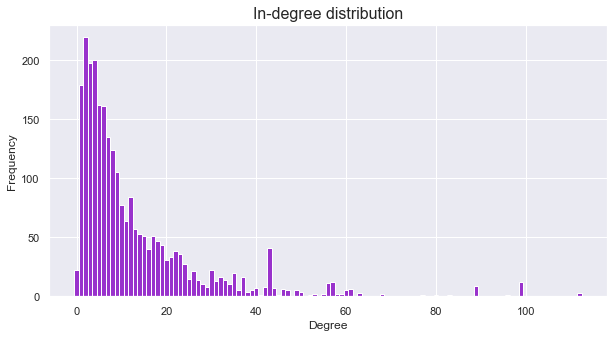

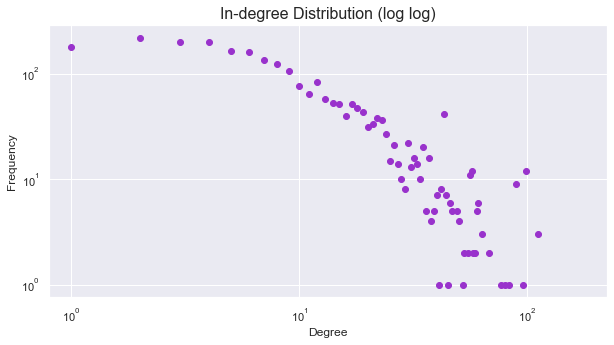

In [9]:
# In-degree distribution
degree_sequence = sorted([d for n, d in G.in_degree()])  
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

sns.set()

fig, ax = plt.subplots(figsize=(10,5))
plt.bar(deg, cnt, width=1, color="#9932CC")
plt.title("In-degree distribution", fontsize=16)
plt.ylabel("Frequency", fontsize=12)
plt.xlabel("Degree", fontsize=12)

fig, ax = plt.subplots(figsize=(10,5))
plt.scatter(deg, cnt, color="#9932CC")
ax.set_xscale('log')
ax.set_yscale('log')
plt.title("In-degree Distribution (log log)", fontsize=16)
plt.ylabel("Frequency", fontsize=12)
plt.xlabel("Degree", fontsize=12)
ax.set_xlim(0.8, np.max(deg)*2)

plt.show()

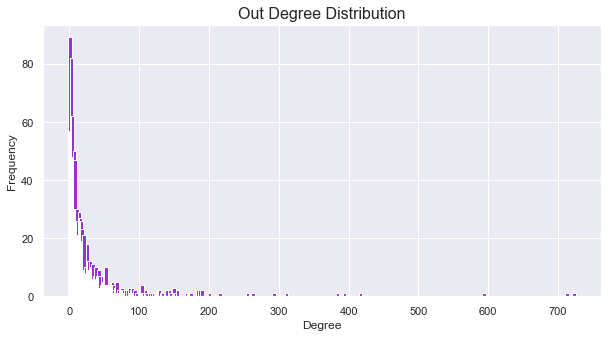

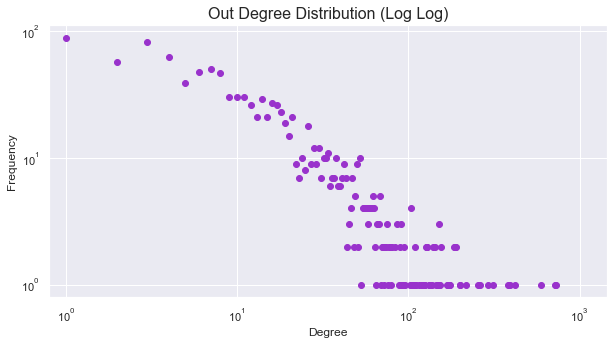

In [10]:
degree_sequence = sorted([d for n, d in G.out_degree()])  
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

sns.set()
deg = deg[1:len(cnt)]
cnt = cnt[1:len(cnt)]
fig, ax = plt.subplots(figsize=(10,5))
plt.bar(deg, cnt, width=5, color="#9932CC")
plt.title("Out Degree Distribution", fontsize=16)
plt.ylabel("Frequency", fontsize=12)
plt.xlabel("Degree", fontsize=12)


fig, ax = plt.subplots(figsize=(10,5))
plt.scatter(deg, cnt, color="#9932CC")
ax.set_xscale('log')
ax.set_yscale('log')
plt.title("Out Degree Distribution (Log Log)", fontsize=16)
plt.ylabel("Frequency", fontsize=12)
plt.xlabel("Degree", fontsize=12)
ax.set_xlim(0.8, np.max(deg)*2)

plt.show()

Both in- and out-degree distributions seem to follow a power law, where a lot of nodes have a small degree, while few nodes have large degrees. The distributions are different in that the out degree distribution has a much larger range of degrees (0-700) and therefore is more spread. Comparing the degree distribution to a random network with the same number of nodes and probability of connection $p$:

In [11]:
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 2590
Number of edges: 33381
Average in degree:  12.8884
Average out degree:  12.8884


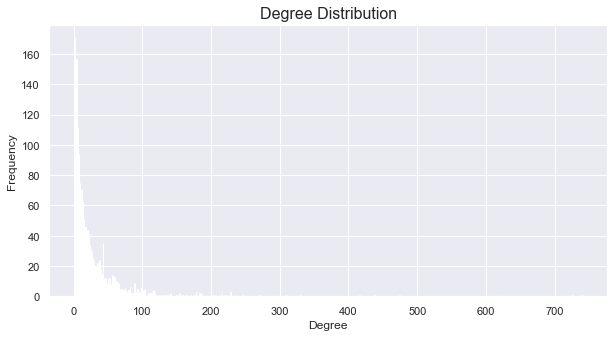

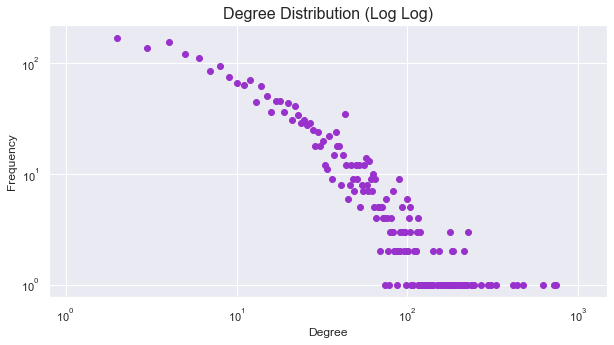

In [12]:
degree_sequence = sorted([d for n, d in G.degree()])  
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

sns.set()
deg = deg[1:len(cnt)]
cnt = cnt[1:len(cnt)]
fig, ax = plt.subplots(figsize=(10,5))
plt.bar(deg, cnt, width=1, color="#9932CC")

plt.title("Degree Distribution", fontsize=16)
plt.ylabel("Frequency", fontsize=12)
plt.xlabel("Degree", fontsize=12)


fig, ax = plt.subplots(figsize=(10,5))
plt.scatter(deg, cnt, color="#9932CC")
ax.set_xscale('log')
ax.set_yscale('log')
plt.title("Degree Distribution (Log Log)", fontsize=16)
plt.ylabel("Frequency", fontsize=12)
plt.xlabel("Degree", fontsize=12)
ax.set_xlim(0.8, np.max(deg)*2)


plt.show()

Looks the same, indicating the character network is random. 

## Exercise 1b: Vizualisation

In [13]:
# Get positions of nodes
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=4.0,
                        strongGravityMode=False,
                        gravity=0.5,

                        # Log
                        verbose=True)

# Determine node positions
positions = forceatlas2.forceatlas2_networkx_layout(GCC, pos=None, iterations=300)

100%|██████████| 300/300 [00:14<00:00, 20.71it/s]

BarnesHut Approximation  took  4.26  seconds
Repulsion forces  took  9.59  seconds
Gravitational forces  took  0.05  seconds
Attraction forces  took  0.11  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds


In [14]:
# color the nodes based on universe
color_map = []
for n in nodeDict:
    universe = nodeDict[n]['type']

    if universe == 'DC':
        color_map.append("blue")
        
    elif universe == 'Marvel':
        color_map.append("green")

    else:
        color_map.append("orange")

In [15]:
# Scale node size according to degree
size = []
degrees = list(GCC.degree())

for i in range(len(GCC.nodes())):
    size.append(degrees[i][1] * 3)

In [16]:
# Make edge colors depending on which nodes they connect
edge_colors = []

for u, v in GCC.edges():
    u_world = GCC.nodes[u]["type"]
    v_world = GCC.nodes[v]["type"]

    if u_world == "DC" and v_world == "DC":
            edge_colors.append("blue") 
    elif u_world == 'Marvel' and v_world == "Marvel":
            edge_colors.append("green") 
    else:
            edge_colors.append("orange")  

legend_elements = [Line2D([0], [0], marker='o', color='w', label='DC',
                          markerfacecolor="blue", markersize=10, alpha=0.6),
                   Line2D([0], [0], marker='o', color='w', label='Marvel',
                          markerfacecolor="green", markersize=10, alpha=0.6),
                   Line2D([0], [0], color="blue", label='DC to DC'),
                   Line2D([0], [0], color="green", label='Marvel to Marvel'),
                   Line2D([0], [0], color="orange", label="DC to Marvel")]

In [ ]:
# Plot
plt.figure(figsize=(15,10))
nx.draw_networkx_nodes(GCC, positions, node_size=size, node_color=color_map, alpha=0.95)
nx.draw_networkx_edges(GCC, positions, edge_color = edge_colors,  alpha=0.45)
plt.legend(handles=legend_elements, facecolor='white', framealpha=1)
plt.axis('off')
plt.show()

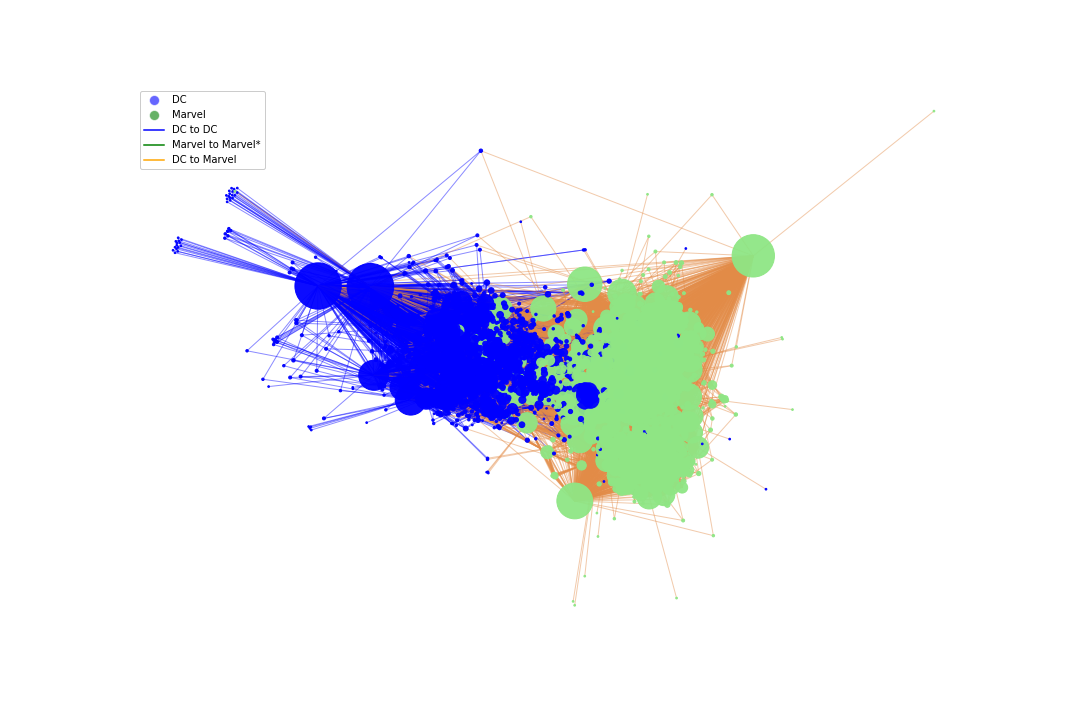

# Exercise 2

In [19]:
# Paths to files
mar_list = glob.glob(os.path.join(os.getcwd(), '/Users/maikalindkvistjensen/Desktop/Skola/Soc2/FINAL_ASSIGNMENTS/wikipages_MAR', "*.txt"))
dc_list = glob.glob(os.path.join(os.getcwd(), '/Users/maikalindkvistjensen/Desktop/Skola/Soc2/FINAL_ASSIGNMENTS/wikipages_DC', "*.txt"))

In [20]:
# make lists containing all pages
mar_dict = {}
for file_path in mar_list:
    with open(file_path, encoding="utf8") as f_input:
        mar_dict[Path(file_path).stem] = f_input.read()

dc_dict = {}
for file_path in dc_list:
    with open(file_path, encoding="utf8") as f_input:
        dc_dict[Path(file_path).stem] = f_input.read()

In [21]:
# Add stopwords
punctuation = string.punctuation + '``' + '--' + '|'
stopwords = nltk.corpus.stopwords.words('english')
skip = stopwords  

# convert to dict 
mar_token = {}
for key in mar_dict:
    mar_token[key] = [word.lower() for word in word_tokenize(mar_dict[key]) if word not in skip and word not in punctuation]

dc_token = {}
for key in dc_dict:
    dc_token[key] = [word.lower() for word in word_tokenize(dc_dict[key]) if word not in skip and word not in punctuation]

In [22]:
# join all strings
mar_token_string = {}
for key in mar_token:
    mar_token_string[key] = (" ").join(mar_token[key])

dc_token_string = {}
for key in dc_token:
    dc_token_string[key] = (" ").join(dc_token[key])

In [23]:
# Tokenize
for key in mar_token:
    mar_token[key] = re.findall('\w+', mar_token_string[key])

for key in dc_token:
    dc_token[key] = re.findall('\w+', dc_token_string[key])

# to list    
mar_tokenlist = list(mar_token.values())
mar_tokenlist = functools.reduce(operator.iconcat, mar_tokenlist, [])

dc_tokenlist = list(dc_token.values())
dc_tokenlist = functools.reduce(operator.iconcat, dc_tokenlist, [])

In [24]:
# make TF dicts
mar_TF = nltk.FreqDist(mar_tokenlist)
dc_TF = nltk.FreqDist(dc_tokenlist)

# make TFTR lists
mar_TFTR = {}
dc_TFTR = {}

In [25]:
c = 1

for key in mar_TF:
    wt_mar = mar_TF[key]/(dc_TF[key] + c)
    mar_TFTR[key] = mar_TF[key] * wt_mar

for key in dc_TF:
    wt_dc = dc_TF[key]/(mar_TF[key] + c)
    dc_TFTR[key] = dc_TF[key] * wt_dc

In [26]:
# words in list n times 
mar_wordcloudlist = []
dc_wordcloudlist = []

for key in mar_TFTR:
    val = math.ceil(mar_TFTR[key]/10)
    mar_wordcloudlist.extend([key] * val)

for key in dc_TFTR:
    val = math.ceil(dc_TFTR[key]/10)
    dc_wordcloudlist.extend([key] * val)

mar_wordcloudlist = (" ").join(mar_wordcloudlist)
dc_wordcloudlist = (" ").join(dc_wordcloudlist)

In [27]:
# generate wordclouds
mar_mar = WordCloud(max_font_size=40, collocations = False, background_color='white').generate(mar_wordcloudlist)
mar_dc = WordCloud(max_font_size=40, collocations = False, background_color='white').generate(dc_wordcloudlist)

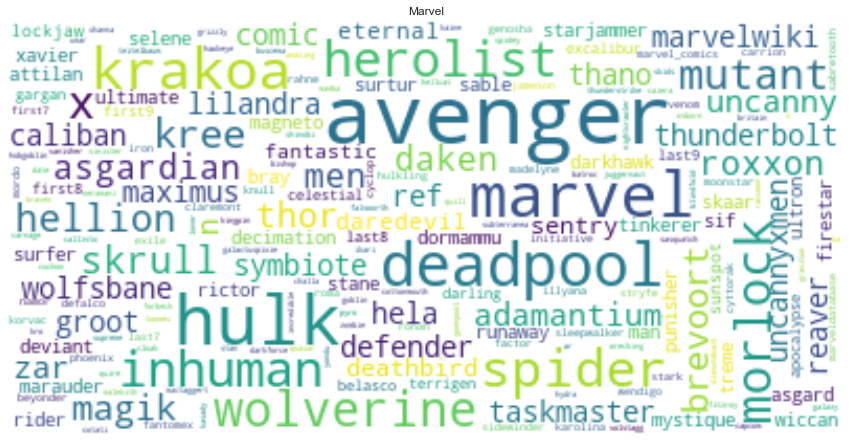

In [28]:
# plot wordclouds
title = "Marvel"
plt.figure(figsize=(15,20))
plt.title(title)
plt.axis("off")
plt.imshow(mar_mar, interpolation="bilinear")

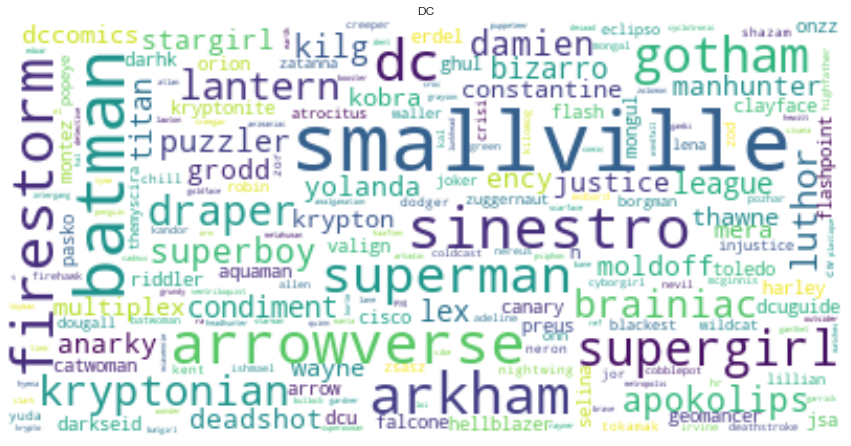

In [29]:
title = "DC"
plt.figure(figsize=(15,20))
plt.title(title)
plt.axis("off")
plt.imshow(mar_dc, interpolation="bilinear")

We see that many of the most common words are typical for each respective universe.

# Exercise 3

To find the communities, the Louvain algorithm is used and the highest partition of the dendrogram generated by this algorithm is chosen.

In [30]:
# Find communities
partition = community_louvain.best_partition(GCC)
print("Number of communities:", max(partition.values())+1)

Number of communities: 6


In [31]:
# list with each community
community_dicts = []
for i in range(max(partition.values())):
    community_dict = {}
    for key in partition:
        if partition[key] == i:
            community_dict[key] = H.degree(key)
    community_dicts.append(community_dict)

In [32]:
Communities = list(set(partition.values()))

Counter(list(partition.values())) 
Communities = Counter(list(partition.values())).most_common(13)

In [33]:
x =[]
y =[]
for i in range(len(Communities)):
    x.append(Communities[i][0])
    y.append(Communities[i][1])

Text(0, 0.5, 'Number of nodes')

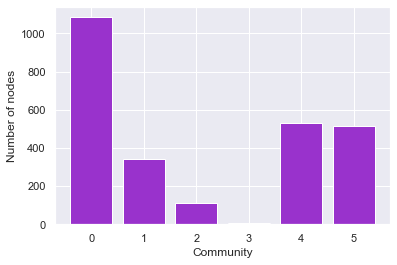

In [34]:
plt.bar(x,y, color ="#9932CC")
plt.xlabel('Community')
plt.ylabel('Number of nodes')

In [35]:
names = []
for comdict in community_dicts:
    name = nlargest(10, comdict, key=comdict.get)
    names.append((", ").join(name))

print(names)

['Superman, Batman, Darkseid, Supergirl, Aquaman, Wizard, Brainiac, Scarecrow, Bizarro, Deathstroke', 'Wolverine, Deadpool, Beast, Cyclops, Storm, Colossus, Psylocke, Nightcrawler, Cable, Sabretooth', 'Vertigo, Nightshade, Lucifer, Witchfire, Spike, Ragnarok, Bast, Zauriel, Brooklyn, Baphomet', 'Everyman, Kiber_the_Cruel, Achebe, Sarge_Steel, Hauptmann_Deutschland, Sylvester_Pemberton, Venomm', 'Spider-Man, Daredevil, Hawkeye, Punisher, Venom, Hood, Kingpin, Taskmaster, Sandman, Electro']


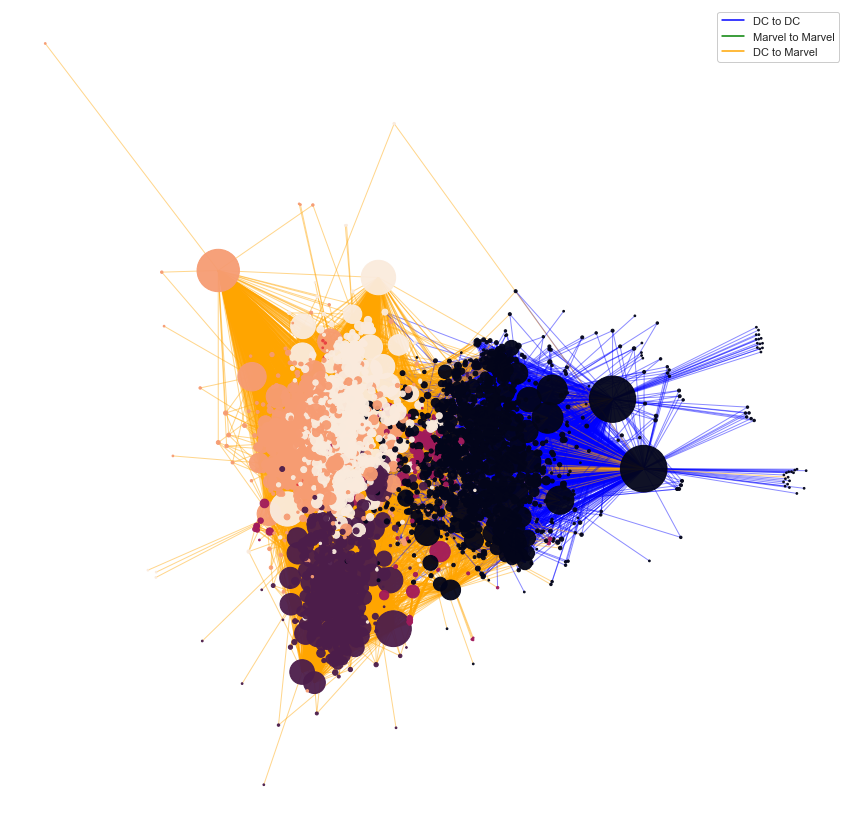

In [36]:
# Graph with communities
legend_elements = [Line2D([0], [0], color="blue", label='DC to DC'),
                   Line2D([0], [0], color="green", label='Marvel to Marvel'),
                   Line2D([0], [0], color="orange", label="DC to Marvel")]

plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(GCC, positions, node_size=size, node_color=list(partition.values()), alpha=0.95)
nx.draw_networkx_edges(GCC, positions, edge_color = edge_colors,  alpha=0.45)
plt.axis('off')
plt.legend(handles=legend_elements, facecolor='white', framealpha=1)
plt.show()

In [37]:
# 5 largest communities
large_com = Counter(list(partition.values())).most_common(5)

Com = []

for i in large_com:
    Com.append(i[0])

In [38]:
# Save the documents in a list with one list for each community

path = r'./wikipages_dc/' 
dc_files = glob.glob(path + "/*.txt")
path = r'./wikipages_mar/'
mar_files = glob.glob(path + "/*.txt")

community_corpus = []

for i in Com:
    document = []
    for file_path in dc_files:
        with open(file_path, encoding="utf8") as f_input:
            if Path(file_path).stem in list(characters['CharacterName']):
                name = characters.loc[characters['CharacterName'] == Path(file_path).stem, 'CharacterName'].iloc[0]
                if name in list(partition.keys()) and partition[name] == i:
                    document.append(f_input.read())
    for file_path in mar_files:
        with open(file_path, encoding="utf8") as f_input:
            if Path(file_path).stem in list(characters['CharacterName']):
                name = characters.loc[characters['CharacterName'] == Path(file_path).stem, 'CharacterName'].iloc[0]
                if name in list(partition.keys()) and partition[name] == i:
                    document.append(f_input.read())
    document = " ".join(document)
    community_corpus.append(document)

In [39]:
word_corpus = []
for document in community_corpus:
    word_corpus.append(re.findall('\w+', document))

In [40]:
# Define punctuation and odd words
punctuation = string.punctuation + '``' + '--' + '|'
stopwords = nltk.corpus.stopwords.words('english')
odd = ["''", 'text', 'name=', '\'s', 'title', 'date', 'https', 'n', 'web', 'url', 'archive', 'access', 'publisher','category']
skip = stopwords + odd 

In [41]:
# clean the text
community_corpus_clean = []

for document in word_corpus:
    # remove punctuation and set to lower case
    community_corpus_clean.append([word.lower() for word in document if word not in skip])

In [42]:
# Calculate the term frequency (TF) of each word
document_TF = []

for document in community_corpus_clean:
    document_TF.append(nltk.FreqDist(document))

In [43]:
# Calculate the TFTR
TFTR = [{} for i in range(0, len(document_TF))]
   
for i in range(0, len(document_TF)):
    for key in document_TF[i]:
        if key not in skip:
            TFTR[i][key] = document_TF[i][key]

In [44]:
import math

# calculate IDF for each word in each community
IDF = []
for document in TFTR:
    idf = {}
    N = len(community_corpus_clean)
    appear = 0
    for word in document:
        appear = sum(1 for doc in TFTR if (word in doc))    
        idf[word] = math.log(N/(1 + appear), 2) + 1
    IDF.append(idf)

In [45]:
# Calculte TFIDF for each word in each community
TFIDF = []
for i in range(0, len(IDF)):
    tfidf = {}
    for word in IDF[i]:
        tfidf[word] = IDF[i][word] * TFTR[i][word]
    TFIDF.append(tfidf)

In [46]:
# Calculte TFIDF for each word in each community
TFIDF = []
for i in range(0, len(IDF)):
    tfidf = {}
    for word in IDF[i]:
        tfidf[word] = IDF[i][word] * TFTR[i][word]
    TFIDF.append(tfidf)

In [47]:
wordlist = []

for document in TFIDF:
    community_list = []
    for word in document:
        val = math.ceil(document[word]/10)
        community_list.extend([word] * val)
    community_list = (" ").join(community_list)
    wordlist.append(community_list)

In [48]:
wordcloud = []
for i in range(0, len(wordlist)):
    wordcloud.append(WordCloud(max_font_size=40, collocations = False, background_color='white').generate(wordlist[i]))

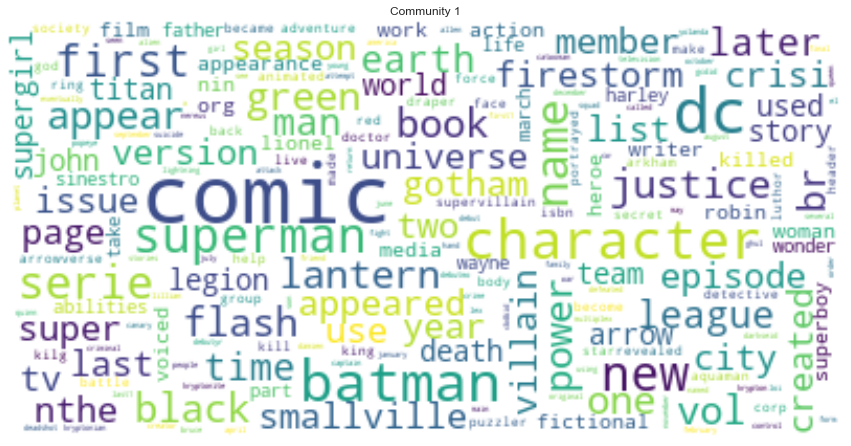

In [49]:
title = "Community 1"
plt.figure(figsize=(15,20))
plt.title(title)
plt.axis("off")
plt.imshow(wordcloud[0], interpolation="bilinear")

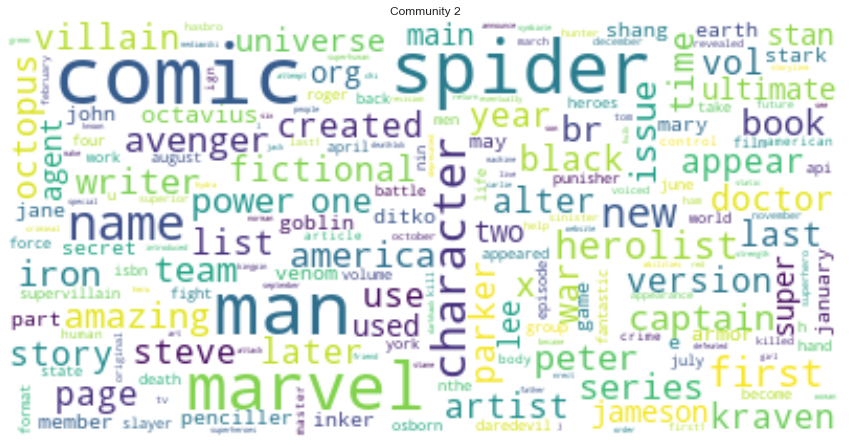

In [50]:
title = "Community 2"
plt.figure(figsize=(15,20))
plt.title(title)
plt.axis("off")
plt.imshow(wordcloud[1], interpolation="bilinear")

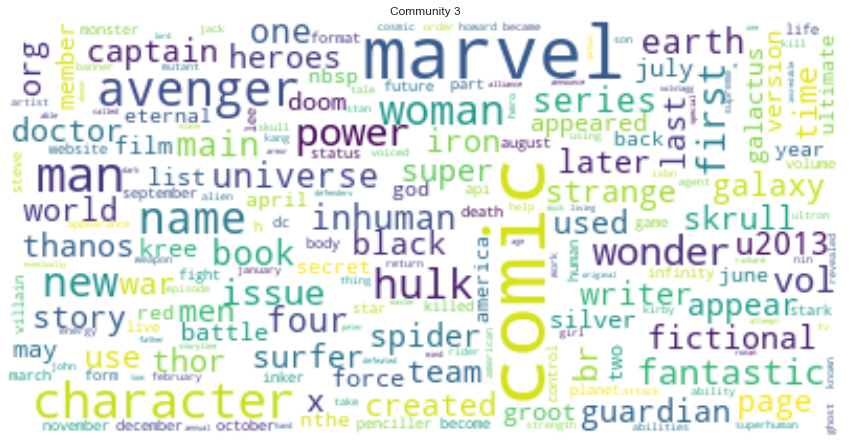

In [51]:
title = "Community 3"
plt.figure(figsize=(15,20))
plt.title(title)
plt.axis("off")
plt.imshow(wordcloud[2], interpolation="bilinear")

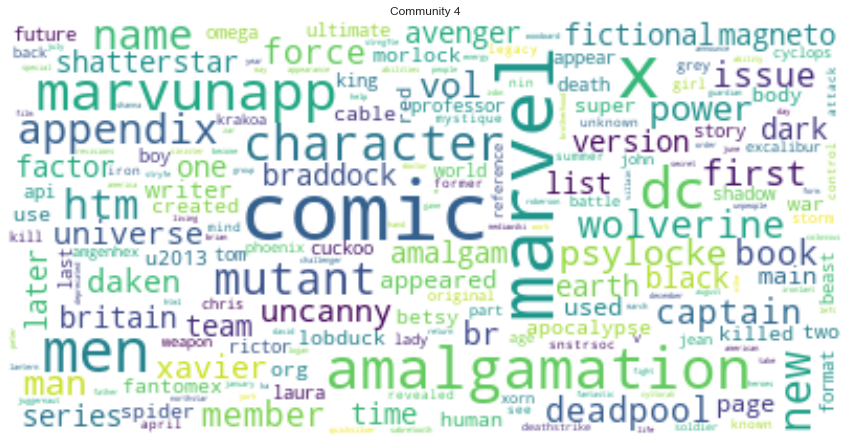

In [52]:
title = "Community 4"
plt.figure(figsize=(15,20))
plt.title(title)
plt.axis("off")
plt.imshow(wordcloud[3], interpolation="bilinear")

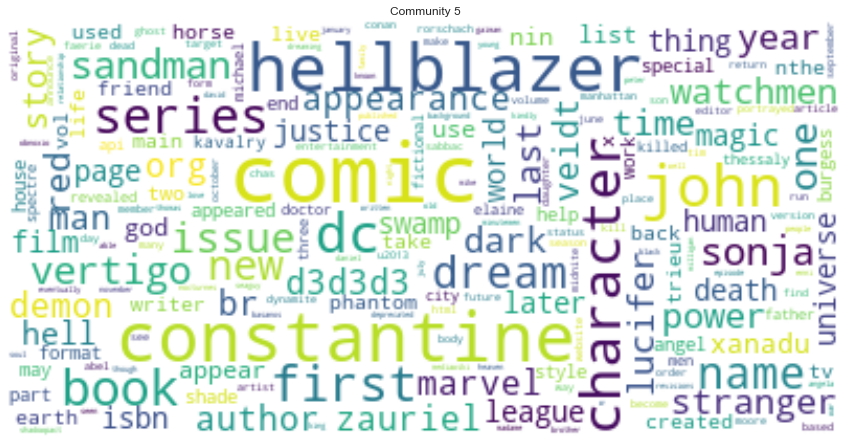

In [53]:
title = "Community 5"
plt.figure(figsize=(15,20))
plt.title(title)
plt.axis("off")
plt.imshow(wordcloud[4], interpolation="bilinear")

The different wordclouds contain semi different words, though many common ones (character, comic, book). Some words separate the "groups" based on which characters are in which (community 1: superman, batman, power, community 2: spider, (peter) parker, herolist, etc).

# Exercise 4

In this section, the sentiment of the groups is analysed using the labMT dataset. 

In [54]:
# Load data
LabMT = pd.read_csv('/Users/maikalindkvistjensen/Desktop/labMIT.txt', sep= "\t")

In [55]:
# Concatenate
def sentiment(tokens):
    df = pd.DataFrame(tokens,columns=['word'])
    return pd.DataFrame(df, columns=['word']).merge(LabMT, on = 'word').happiness_average.mean()

In [56]:
# List of files
mar_list = glob.glob(os.path.join(os.getcwd(), '/Users/maikalindkvistjensen/Desktop/Skola/Soc2/FINAL_ASSIGNMENTS/wikipages_MAR', "*.txt"))
dc_list = glob.glob(os.path.join(os.getcwd(), '/Users/maikalindkvistjensen/Desktop/Skola/Soc2/FINAL_ASSIGNMENTS/wikipages_DC', "*.txt"))

In [57]:
# Dicts with all text
character_dict = {}
for file_path in mar_list:
    with open(file_path, encoding="utf8") as f_input:
        character_dict[Path(file_path).stem] = f_input.read()
for file_path in dc_list:
    with open(file_path, encoding="utf8") as f_input:
        character_dict[Path(file_path).stem] = f_input.read()

In [58]:
# Sentiment for each page
page_sentiment = dict()

for key in character_dict:
    tokens = word_tokenize(character_dict[key])
    page_sentiment[key] = sentiment(tokens)

In [59]:
clean = {k: v for k, v in page_sentiment.items() if pd.Series(v).notna().all()}

In [60]:
# happiest character pages
s = pd.Series(clean)
s.nlargest(10)

Joystick_(comics)       6.880000
Transonic_(comics)      5.762686
Fixx_(Marvel_comics)    5.761087
Taki_Matsuya            5.757877
Free_Spirit_(comics)    5.680946
Buzz_(comics)           5.616494
Teen_humor_comics       5.605314
Wildstreak              5.579100
Yankee_Doodle_Boy       5.572784
Melissa_Broder          5.566317
dtype: float64

In [61]:
# saddest character pages
s = pd.Series(clean)
s.nsmallest(10)

Megafire_(page_to_delete)    4.746667
Clawster                     5.110814
Sin-Eater_(comics)           5.118227
Hitman_(Marvel_Comics)       5.139542
Rainbow_Archer               5.141423
Giganto                      5.150459
Lew_Moxon                    5.154113
Savage_Steel                 5.156506
Battle_axe                   5.157278
Karthon_the_Quester          5.158358
dtype: float64

There is not a large difference in sentiment between the happiest and saddest character pages. 

In [62]:
# make two dicts containing all pages
dc_dict = {}
mar_dict = {}
for file_path in dc_list:
    with open(file_path, encoding="utf8") as f_input:
        mar_dict[Path(file_path).stem] = f_input.read()
for file_path in mar_list:
    with open(file_path, encoding="utf8") as f_input:
        dc_dict[Path(file_path).stem] = f_input.read()

In [63]:
dc_sentiment = dict()

for key in dc_dict:
    tokens = word_tokenize(dc_dict[key])
    dc_sentiment[key] = sentiment(tokens)

mar_sentiment = dict()

for key in mar_dict:
    tokens = word_tokenize(mar_dict[key])
    mar_sentiment[key] = sentiment(tokens)

In [64]:
dc_cleaned = [x for x in list(dc_sentiment.values()) if str(x) != 'nan'] 
dc_mean = np.mean(dc_cleaned)
dc_median = np.median(dc_cleaned)
print("DC:", dc_mean)

DC: 5.31703509936922


In [65]:
mar_cleaned = [x for x in list(mar_sentiment.values()) if str(x) != 'nan'] # removes nan's
mar_mean = statistics.mean(mar_cleaned)
mar_median = statistics.median(mar_cleaned)
print("Marvel average:", mar_mean)

Marvel average: 5.324103354603228


Marvel and DC are very close in average sentiment, which makes sense, being that they both contain a mix of characters. 